### This notebook explores a seemingly disconnected population of cells enriched in young neighborhood and metaGEP2 activity in the upper right part of the UMAP in Figs. 1G and 2D. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata as ad

#### Load the data

In [2]:
d = ad.read_h5ad("/Users/kr72/Documents/projects/aging_blood/prepare_for_publication/3_scVI_integration/integrated_seu.h5ad")

# Subset Young and Aged samples
d = d[d.obs.Cohort.isin(['Young', 'Aged'])].copy()

sc.pp.neighbors(d, use_rep='X_scVI')
sc.tl.umap(d)


/Users/kr72/.venvs/MyEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Add CNA results

In [3]:
cna_results = pd.read_csv('/Users/kr72/Documents/projects/aging_blood/prepare_for_publication/7_CNA/cna_results.csv', index_col=0)
print(all(d.obs.index == cna_results.index))
d.obs[['cohort_coef', 'cohort_coef_fdr']] = cna_results

True


#### Add metaGEP scores and predominant programs

In [4]:
program_df = pd.read_csv("/Users/kr72/Documents/projects/aging_blood/prepare_for_publication/revision/programs_df.csv")
program_df = program_df.filter(items =d.obs.index, axis=0)
print(all(d.obs.index == program_df.index))
d.obs = pd.concat([d.obs, program_df], axis=1)

True


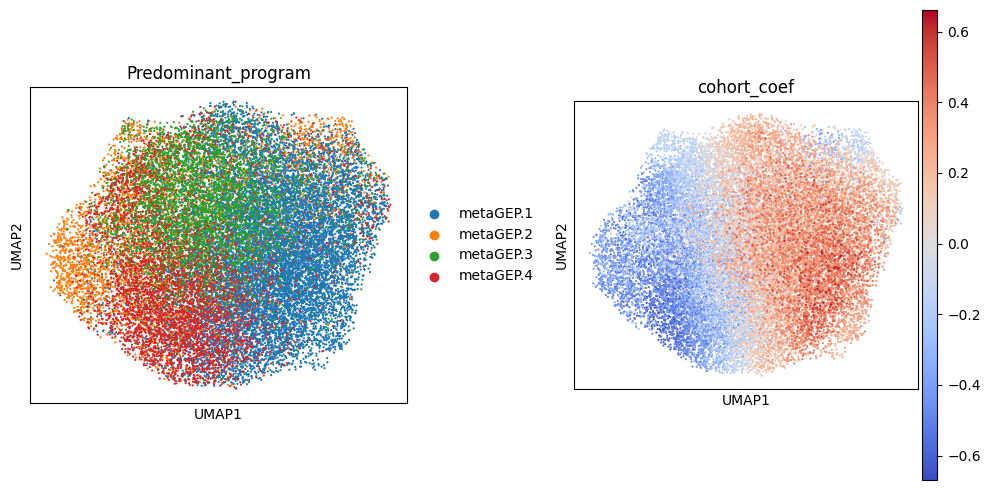

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(d, color="Predominant_program", size=10, ax=axs[0], show=False)
sc.pl.umap(d, color="cohort_coef", size=10, ax=axs[1], show=False, cmap="coolwarm")
for ax in axs:
    ax.set_aspect('equal', adjustable='box') 
plt.tight_layout()

The upper right part of the UMAP contains a population of cells enriched for **metaGEP2** and negative CNA scores (which implies that on the neighborhood graph, these cells are surrounded by cells from young samples). This suggests that this subpopulation is *transcriptionally young rather than aged*, raising the question of the validity of this projection.

Let's define a population of interest, **metaGEP2 of interest** on plots below, and see how it behaves on different projections:

In [6]:
cells_of_interest_mask = (
    (d.obsm["X_umap"][:, 0] > np.quantile(d.obsm["X_umap"][:, 0], 0.75))
    & (d.obsm["X_umap"][:, 1] > np.quantile(d.obsm["X_umap"][:, 1], 0.75))
    & (d.obs.Predominant_program == "metaGEP.2")
)

metaGEP2_mask = (d.obs.Predominant_program == "metaGEP.2")

labels = np.full(d.n_obs, "rest", dtype=object)
labels[metaGEP2_mask & ~cells_of_interest_mask] = "metaGEP2 rest"
labels[cells_of_interest_mask] = "metaGEP2 of interest"

order = ["rest", "metaGEP2 rest", "metaGEP2 of interest"]
d.obs["complementary_cells_groups"] = pd.Categorical(labels, categories=order, ordered=True)

cat_to_order = {cat: i for i, cat in enumerate(order)}

codes = d.obs["complementary_cells_groups"].map(cat_to_order)

ordered_indices = np.argsort(codes.values)

palette = {
    "metaGEP2 of interest": "#d62728",  # red
    "metaGEP2 rest": "#1f77b4",         # blue
    "rest": "#c7c7c7"                   # gray
}

# Define shuffled indices for visualization 
random_indices=np.random.permutation(list(range(d.shape[0])))

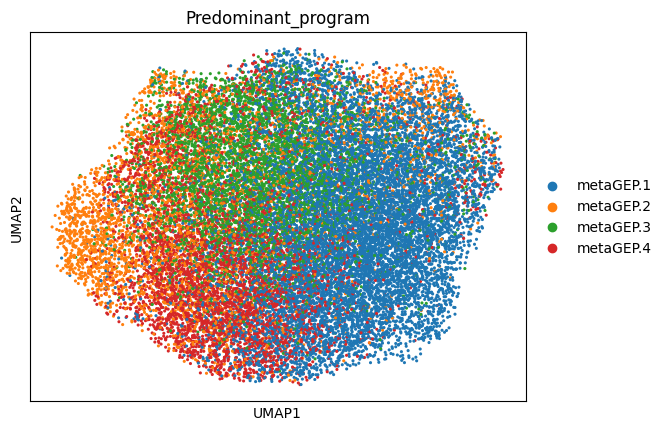

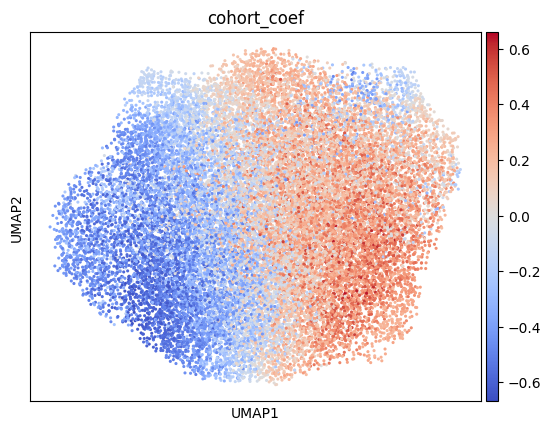

/Users/kr72/.venvs/MyEnv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


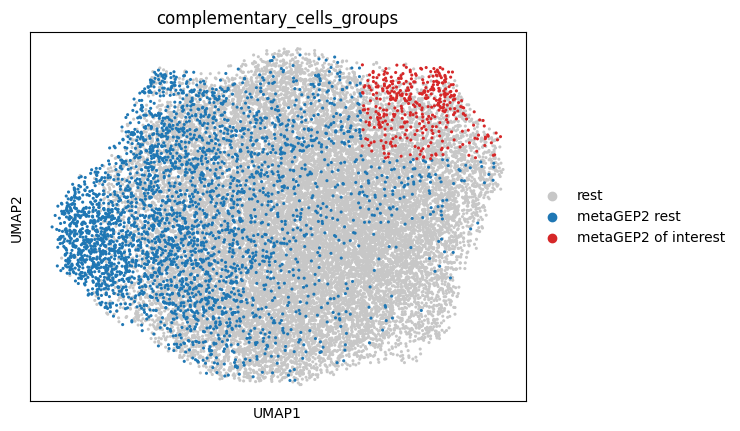

In [7]:
sc.pl.umap(d[random_indices,:], color="Predominant_program", size=20, show=True)
sc.pl.umap(d[random_indices,:], color="cohort_coef", size=20, show=True, cmap="coolwarm", sort_order=False)
sc.pl.umap(d[ordered_indices,:], color="complementary_cells_groups", size=20, show=True, palette=palette)

The bottom panel marks metaGEP2 cells that are visually disconnected from the rest as red, and the remaining metaGEP2 cells in blue. While the red population occupies peripheral areas bordering populations predominated by other meta-programs, it is not completely disconnected from the rest of metaGEP2-driven cells (blue). Looking at the relative position of the red subpopulation in 3D projection makes it more clear.

### 3D UMAP

Projecting the same neighborhood graph onto 3D space releases some of the stress in the 2D projection, and the population in question appears less visually disconnected both in terms of the distribution of predominant programs and CNA scores. In every projection, the red population is still connected to the remainder of metaGEP2-driven population (blue).

In [8]:
sc.tl.umap(d, n_components=3)

/Users/kr72/.venvs/MyEnv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


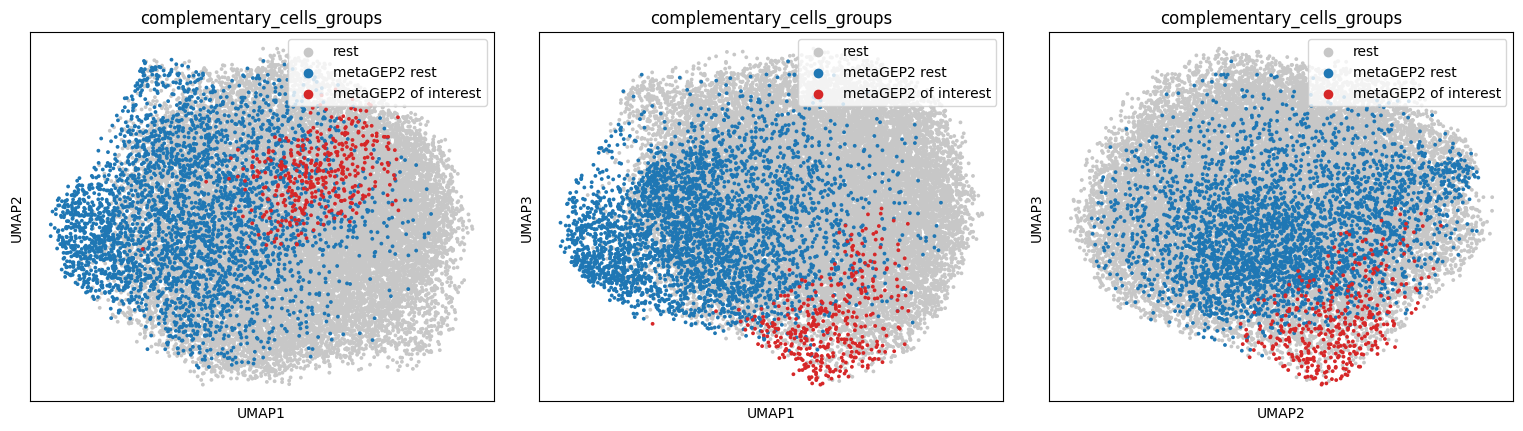

In [9]:
# sc.pl.umap(d[random_indices,:], color="Predominant_program", size=30, show=True, components="all", legend_loc="upper right", wspace=0)
# sc.pl.umap(d[random_indices,:], color="cohort_coef", size=30, show=True, cmap="coolwarm", components="all", sort_order=False, legend_loc="upper right", wspace=0.05)
sc.pl.umap(d[ordered_indices,:], color="complementary_cells_groups", size=30, palette=palette, show=True, components="all", sort_order=True, legend_loc="upper right", wspace=0)


We can also check how well graph-based distances are preserved in 2D UMAP.

In [10]:
import scipy.sparse as sp
from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import pairwise_distances

# Return to the 2D projection
sc.tl.umap(d, n_components=2)

# Get graph-based distances
G = d.obsp["distances"].tocsr()
geo = shortest_path(G, directed=False, unweighted=False)

# Get UMAP-based distances
umapD = pairwise_distances(d.obsm["X_umap"])

# per-cell Spearman corr between graph- and UMAP-based distances
from scipy.stats import spearmanr
rho = np.array([spearmanr(geo[i], umapD[i]).correlation for i in range(G.shape[0])])

# Add correlations to the object
d.obs["distance_cor"] = rho

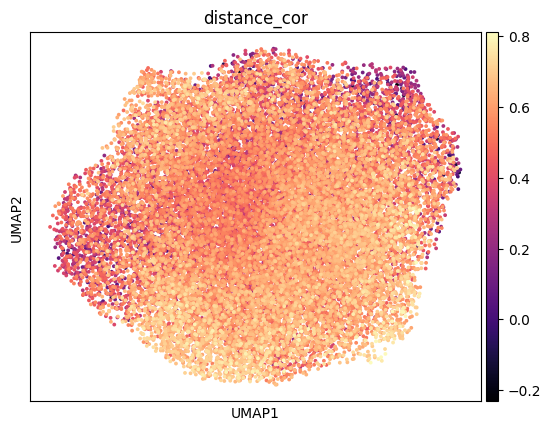

In [11]:
sc.pl.umap(d[random_indices,:], color="distance_cor", size=30, cmap="magma")

We can notice that the area in the upper right part of the UMAP shows lower correlation values, implying that the agreement between the graph and the projected representation is lower there. Indeed, our metaGEP2-driven cells of interest have lower correlation values compared to the rest of the population.

/Users/kr72/.venvs/MyEnv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `scale` is deprecated, use `density_norm` instead
  return fn(*args_all, **kw)
/Users/kr72/.venvs/MyEnv/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


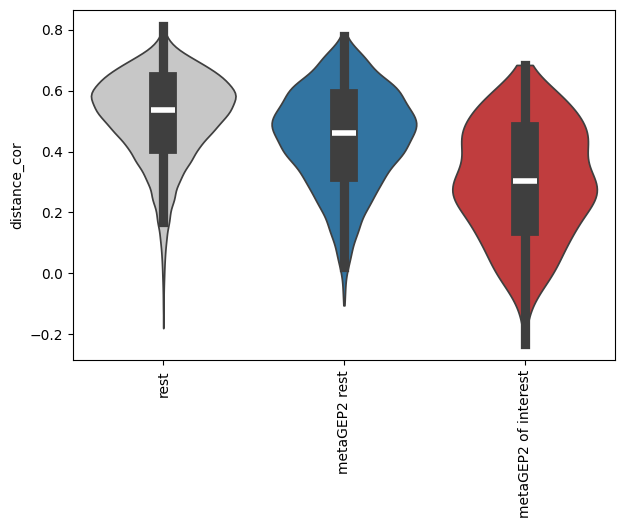

In [12]:
sc.pl.violin(
    d,
    keys="distance_cor",
    groupby="complementary_cells_groups",
    order=order,
    stripplot=False,
    scale="width", rotation=90,
    palette=palette,      
    inner="box", inner_kws = {'box_width':20}
)

# ===

To summarize these observations, the UMAP projection does not perfectly represent the underlying graph structure and should be interpreted with caution. The population in the upper right area of the 2D UMAP is predominated by metaGEP2-driven cells whose neighborhoods are enriched with cells coming from young donors, and is a part of the entire metaGEP2-driven population.